# VAE

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import display

batch_size = 64 # バッチサイズ
nz = 100 # 潜在変数の次元数
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')


---


In [2]:
dataset = MNIST(
    root="data/",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True
)

sample_x, _ = next(iter(dataloader))
w, h = sample_x.shape[2:]
image_size = w * h
print("batch shape:", sample_x.shape)
print("width:", w)
print("height:", h)
print("image size:", image_size)

batch shape: torch.Size([64, 1, 28, 28])
width: 28
height: 28
image size: 784


In [3]:
@torch.no_grad()
def draw(model, n_images=10, width=800):
    model.eval()
    x, _ = next(iter(dataloader))
    x = x.to(device)[:n_images]
    y, _, _ = model(x)
    img = torch.cat([x, y], dim=0).cpu()
    img = transforms.Resize((width // n_images), antialias=True)(img)
    img = torchvision.utils.make_grid(img, nrow=n_images)
    img = transforms.functional.to_pil_image(img)
    display(img)


---


In [4]:
class VAE(nn.Module):
    def __init__(self, z_dim):
        super(VAE, self).__init__()
        self.z_dim = z_dim
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, z_dim*2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        mean, std = self.encoder(x).chunk(2, dim=1)
        z = mean + torch.randn(self.z_dim)*std
        y = self.decoder(z).view(-1, 1, 28, 28)
        return y, mean, std


---


In [5]:
mse = nn.MSELoss()
def loss_fn(x, y, mean, std):
    var = std**2
    loss_recons = mse(x, y)
    loss_reg = 0.5 * torch.sum(1 + torch.log(var) - mean**2 - var)
    return loss_recons - loss_reg

def train(model, optimizer, n_epochs):
    for epoch in range(n_epochs):
        for x, _ in dataloader:
            optimizer.zero_grad()
            x = x.to(device)
            y, mean, std = model(x)
            loss = loss_fn(x, y, mean, std)
            loss.backward()
            optimizer.step()
        print(f'{epoch+1}epoch loss:{loss.item()}')


---


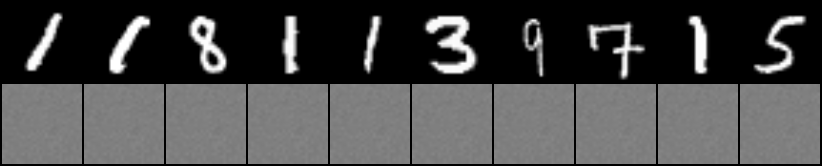

In [6]:
z_dim = 10
vae = VAE(z_dim)
optimizer = optim.Adam(vae.parameters())
draw(vae)

In [7]:
train(vae, optimizer, 10)

1epoch loss:0.4785587191581726
2epoch loss:0.2871125340461731
3epoch loss:0.2337149679660797
4epoch loss:0.14155074954032898
5epoch loss:0.1798911839723587
6epoch loss:0.11208705604076385
7epoch loss:0.08098293095827103
8epoch loss:0.09951377660036087
9epoch loss:0.13555070757865906
10epoch loss:0.07252109795808792


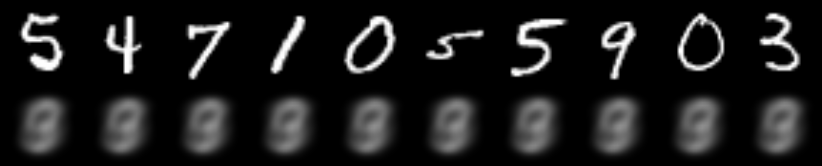

In [8]:
draw(vae)